# Image-to-Image Translation with a CNN
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/cnn_conus_clouds.ipynb)

This notebook was create by Jamin Rader [CSU] with HUGE THANKS to Kyle Hilburn [CIRA/CSU] for getting the data processed, providing us with some code, and letting us know ahead of time that the prediction would be successful.

__PROBLEM SETUP__

Here is the (fictional) situation. It's 2019, and all the NEXRAD radars have gone down! We no longer have measurements of reflectivity to help us with our forecasts. Fortuantely, we have GOES Cloud-top Imagery (Channel 13) and data from the Geostationary Lightning Mapper (GLM). Can we use these data to predict radar reflectivity as severe storms start to break out?

The idea is to train a convolutional neural network (CNN) to ingest images of GOES and GLM and predict what the MRMS radar reflectivity at each pixel in the image. Although the predictors are images (i.e. maps) the loss function and metrics will be evaluated at each pixel individually and then summed to get the total per predicted radar image.

# 0. Set Up Environments

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = True


In [2]:
!pip install wget
import wget

import sys
import numpy as np
import seaborn as sb
import xarray as xr

import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d90555b1ed463d5cfd4a253ec39766e06285c392a3b4784ec8188c462db95502
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
numpy version = 1.21.5
tensorflow version = 2.8.0


In [4]:
#if(IN_COLAB==True):
#    try:
#        from google.colab import drive
#        drive.mount('/content/drive', force_remount=True)
#        local_path = '/content/drive/My Drive/Colab Notebooks/'
#    except:
#        local_path = './'
#else:
#    local_path = 'figures/'

#1. Data Preparation

### 1.1 Data Overview

Note: This data has already been standardized. A HUGE "thank you" to Kyle Hillburn for sharing this data.




In [5]:
url = 'https://eabarnes-data.atmos.colostate.edu/course_ml_ats/GOES_MRMS_data.nc'
filename = wget.download(url)
data = xr.open_dataset(filename)

Let's take a look at the data.

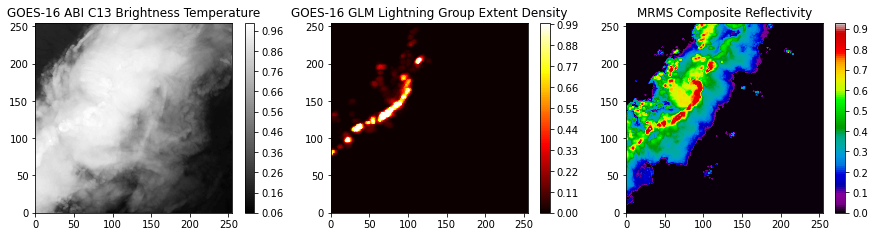

In [6]:
# Defining our input and output fields (features and targets)
input = data['Xdata_train']
output = data['Ydata_train']

fig, axs = plt.subplots(1, 3, figsize = (15, 3.5))

axs[0].set_title('GOES-16 ABI C13 Brightness Temperature')
pcm = axs[0].contourf(input[0,:,:,0], cmap = 'binary_r', levels = 100)
plt.colorbar(pcm, ax = axs[0])

axs[1].set_title('GOES-16 GLM Lightning Group Extent Density')
pcm = axs[1].contourf(input[0,:,:,1], cmap = 'hot', levels=100)
plt.colorbar(pcm, ax = axs[1])

axs[2].set_title('MRMS Composite Reflectivity')
pcm = axs[2].contourf(output[0,:,:], cmap = 'nipy_spectral', levels=100)
plt.colorbar(pcm, ax = axs[2])
plt.show()

### 1.2 Visualizing our Data

What do you know? This is another big class-imbalance problem. There are more zero than non-zero reflectivities. We may have to find a unique approach to solving this problem.

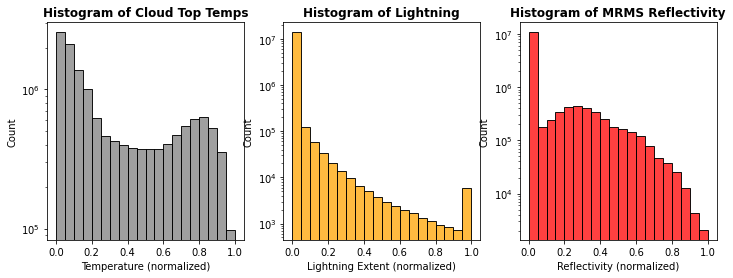

In [7]:
# Distribution of radar returns
fig, axs = plt.subplots( 1, 3, figsize=(12, 4))

sb.histplot(input[:,:,:,0].values.flatten(), bins=20, color='gray', ax=axs[0])
axs[0].set_xlabel('Temperature (normalized)')
axs[0].set_yscale('log')
axs[0].set_title('Histogram of Cloud Top Temps', fontweight='demi')

sb.histplot(input[:,:,:,1].values.flatten(), bins=20, color='orange', ax=axs[1])
axs[1].set_xlabel('Lightning Extent (normalized)')
axs[1].set_yscale('log')
axs[1].set_title('Histogram of Lightning', fontweight='demi')

sb.histplot(output.values.flatten(), bins=20, color='red', ax=axs[2])
axs[2].set_xlabel('Reflectivity (normalized)')
axs[2].set_yscale('log')
axs[2].set_title('Histogram of MRMS Reflectivity', fontweight='demi')

plt.show()

Here we are plotting a subset of the data that we may use for validation. We want to make sure the range of cloud-top temperatures, lightning extent and reflectivity are represented in the validation data too.

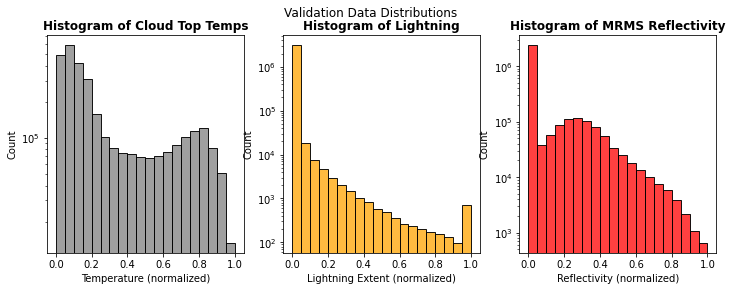

In [8]:
# Distribution of radar returns for potential validation data
fig, axs = plt.subplots( 1, 3, figsize=(12, 4))

sb.histplot(input[-48:,:,:,0].values.flatten(), bins=20, color='gray', ax=axs[0])
axs[0].set_xlabel('Temperature (normalized)')
axs[0].set_yscale('log')
axs[0].set_title('Histogram of Cloud Top Temps', fontweight='demi')

sb.histplot(input[-48:,:,:,1].values.flatten(), bins=20, color='orange', ax=axs[1])
axs[1].set_xlabel('Lightning Extent (normalized)')
axs[1].set_yscale('log')
axs[1].set_title('Histogram of Lightning', fontweight='demi')

sb.histplot(output[-48:].values.flatten(), bins=20, color='red', ax=axs[2])
axs[2].set_xlabel('Reflectivity (normalized)')
axs[2].set_yscale('log')
axs[2].set_title('Histogram of MRMS Reflectivity', fontweight='demi')

plt.suptitle('Validation Data Distributions')
plt.show()

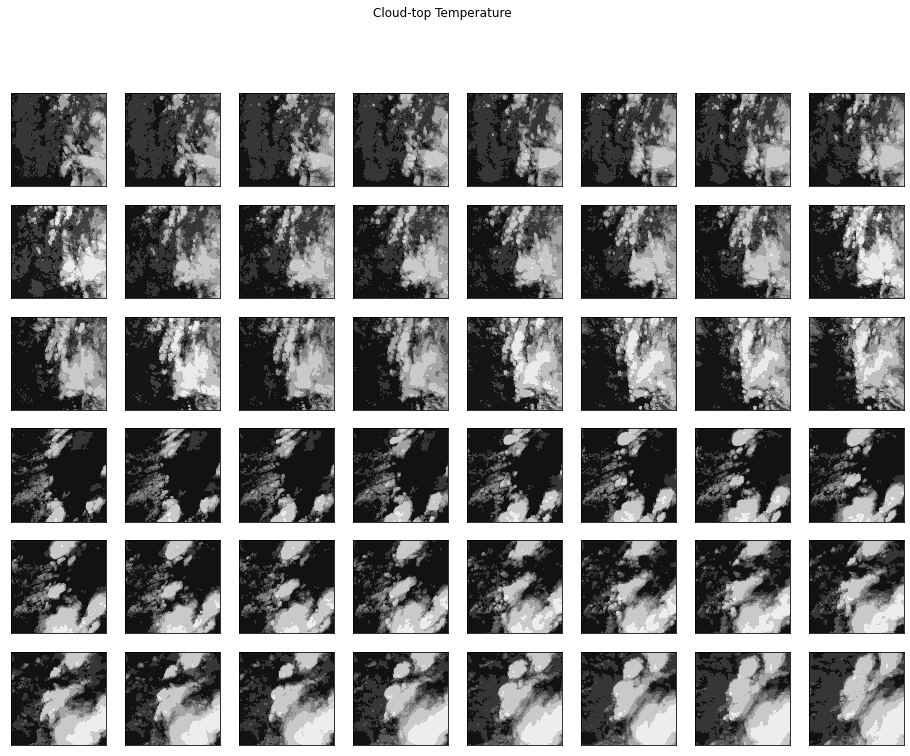

In [9]:
# Take a look at the images (cloud top), currently showing validation events

START_IMG = -48 
END_IMG = None

fig, axs = plt.subplots(6, 8, figsize=(16, 12))
for i,d in enumerate(input[START_IMG:END_IMG,:,:,0]):
  axs[i//8, i%8].contourf(d, cmap='binary_r')
  axs[i//8, i%8].set_yticks([])
  axs[i//8, i%8].set_xticks([])
plt.suptitle('Cloud-top Temperature')
plt.show()

### 1.3 Partitioning Data in Training, Validation, and Testing Sets

Our data is highly temporally correlated, so we are going to separate training, validation, and testing by grabbing different events. *Not* by random sampling.

**Some Variable Definitions**

***Xtrain/Xval/Xtest:*** 4-D Arrays of input data (shape: #samples, #lat, #lon, #channels)

***Ttrain/Tval/Ttest:*** 4-D Arrays of target output data (shape: #samples, #lat, #lon)

***Ptrain/Pval/Ptest:*** 4-D Arrays of predicted output data (shape: #samples, #lat, #lon)

**EDIT the events used for training and validation here:**

In [10]:
# Using the last two events for validation (48 images in total)
VAL_IMG_NUM = 48
TRAIN_RANGE = np.arange(0, 216-VAL_IMG_NUM)
VAL_RANGE = np.arange(216-VAL_IMG_NUM, 216) # Last 48 images for validation

In [11]:
# Splitting into training, testing, validation

# Create the input and output arrays from training, testing, validation sets

Xtrain = input[TRAIN_RANGE].values # these are the inputs (X)
Ttrain = output[TRAIN_RANGE].values # these are the outputs (T is for target)

Xval = input[VAL_RANGE].values
Tval = output[VAL_RANGE].values

print('Shapes:')
print('  Xtrain: ', Xtrain.shape)
print('  Xval: ', Xval.shape)

print('  Ttrain: ', Ttrain.shape)
print('  Tval: ', Tval.shape)

Shapes:
  Xtrain:  (168, 256, 256, 2)
  Xval:  (48, 256, 256, 2)
  Ttrain:  (168, 256, 256)
  Tval:  (48, 256, 256)


Note the "2" in the shape of the Xtrain data. This represents our two predictor variables: Channel 13 Cloud-top Imagery from GOES and the GLM Lightning Extent.

Also, you may notice that we are not standardizing our data here. Kyle Hillburn has done it for us already.

# 2. Neural Network

### 2.1 Building the Model

In [12]:
# Let's import some different things we will use to build the neural network
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, \
Layer, Dense, AveragePooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model

In [13]:
# Define custom metrics and loss functions (feel free to play with your own!)

def r_square_metric(y_true,y_pred):
   ss_res = K.sum(K.square(y_true-y_pred))
   ss_tot = K.sum(K.square(y_true-K.mean(y_true)))
   return ( 1 - ss_res/(ss_tot + K.epsilon()) )

def mean_squared_error_weighted_genexp_loss(weight=(0.0,0.0)):
    def loss(y_true,y_pred):
        return tf.multiply( \
            tf.exp( tf.multiply( weight[0], tf.pow(y_true,weight[1]) ) ) , \
            tf.square(tf.subtract(y_pred,y_true)) )
    return loss

**What is this loss function actually doing?** 

Take a look at the plots below, that compare the loss for different error values (the difference between predicted and true reflectivity) and at different reflectivities. See here how the loss at high reflectivities is much greater than the loss at low reflectivities with the same level of error.

**EDIT: LOSS_WEIGHT in the code cell below to mess with the loss function.** This won't change the loss function in the actual training of the neural network. That step is futher along.

Text(0, 0.5, 'Loss')

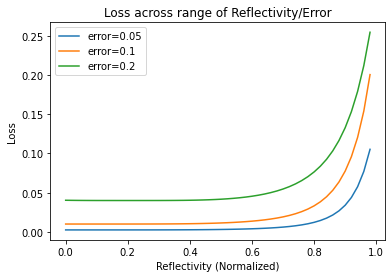

In [14]:
LOSS_WEIGHT_EXP = (5.0,4.0)

for diffval in [.05, .1, .2]:
  loss_list = []
  for val in np.arange(0,1,.02):
    y_true = val
    y_pred = val - diffval
    loss = mean_squared_error_weighted_genexp_loss(weight=LOSS_WEIGHT_EXP)
    loss_list.append(loss(y_pred.astype('float32'), y_true.astype('float32')).numpy())
  plt.plot(np.arange(0,1,.02), loss_list, label = 'error=' + str(diffval))
plt.legend()
plt.title('Loss across range of Reflectivity/Error')
plt.xlabel('Reflectivity (Normalized)')
plt.ylabel('Loss')

In [15]:
### Here is where we actually build the model

def compile_model():
  # This isn't good practice, but model will be a global variable
  global model

  # Input Layers
  input_layer = Input(shape=Xtrain.shape[1:]) # lat x lon x channels

  layers = Layer()(input_layer)

  # Convolutional Layers
  for ilay in range(N_CONV_LAYERS):
    layers = Conv2D(N_FILTERS,KERNEL_SIZE, strides = STRIDE,
                    activation=CONV_ACTIVATION, padding='same')(layers)
  layers = DOWNSAMPLING2D(POOL_SIZE, padding='same')(layers) # MaxPooling2D or AveragePooling2D

  conv_shape = layers.shape

  # Dense Layers (Fully Connected)
  if N_DENSE_LAYERS != 0:
    layers = Flatten()(layers)
    for ilay in range(N_DENSE_LAYERS):
      layers = Dense(N_NODES[ilay], activation=DENSE_ACTIVATION, 
                    kernel_regularizer=keras.regularizers.L1L2(l1=L1[ilay], l2=L2[ilay]))(layers)
    layers = Dense(np.product(conv_shape[1:]))(layers) # Reshapes the array to start upsampling
    layers = Reshape(target_shape = conv_shape[1:])(layers)

  # Transpose Convolutional Layers
  for ilay in range(N_CONV_LAYERS):
    layers = Conv2DTranspose(N_FILTERS,KERNEL_SIZE, strides = STRIDE,
                    activation=CONV_ACTIVATION, padding='same')(layers)
  layers = UpSampling2D(POOL_SIZE)(layers)
  output_layer = Conv2D(1, KERNEL_SIZE, activation='linear', padding='same')(layers)

  # Constructing the model
  model = Model(input_layer, output_layer)
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Using the Adam optimizer
  model.compile(optimizer=optimizer, loss=LOSS, 
                metrics=[METRIC])
  
  model.summary()


### This is the function that will iteratively train the model

def fit_model():
  global history

  # This will allow us to do some explainability
  history = model.fit(Xtrain, Ttrain, epochs=NUM_EPOCHS, verbose=VERBOSITY,
                      batch_size = BATCH_SIZE, shuffle=True,
                      validation_data=[Xval, Tval])

### 2.2 Training the Model

In [16]:
# This builds, compiles, then fits, the model. 
# It's important to recompile the model each time before fitting.

def train_model():
  compile_model()
  fit_model()

**EDIT the model hyperparameters here**

In [17]:
### Here are some model architecture hyperparameters we can mess with

## General Model Choices ##

SEED = 28980 # used for setting random values so results are reproducable

#LOSS = mean_squared_error_weighted_genexp_loss((5.0, 4.0))
LOSS = 'mse' # Loss Function used
METRIC = r_square_metric # Metric for assessing model skill

NUM_EPOCHS = 10 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 32 # Number of samples
VERBOSITY = 1 # 0: Silent during model.fit; 1: Progress bar; 2: Prints each epoch
LEARNING_RATE = .001 # Learning rate (think step size)

## Convolutional Layer Choices ##

N_CONV_LAYERS = 3 # Number of convolutional layers
N_FILTERS = 16 # Number of filters for each convolutional layer
KERNEL_SIZE = (3, 3) # Size of the kernel (window)
STRIDE = (1,1) # Stride for the kernel
CONV_ACTIVATION = 'relu' # Activation function for the convolutional layers

DOWNSAMPLING2D = MaxPooling2D # What function do you want to use for downsampling?
POOL_SIZE = (2, 2) # Size of the window for downsampling

## Dense Layer Choices ##

N_DENSE_LAYERS = 0 # Dense layers are good *if* non-local data is helpful for the prediction
DENSE_ACTIVATION = 'relu' # Activation function for the dense (fully connected) layers
N_NODES = 10 # Number of nodes in the dense layers, int or list of ints
L1 = 0 # Lasso Regularization Penalty
L2 = 0 # Ridge Regularization Penalty


####### DO NOT EDIT BELOW ############

# Converting ints to list if same for all dense layers
if type(L1) != list:
  L1 = [L1] * N_DENSE_LAYERS
if type(L2) != list:
  L2 = [L2] * N_DENSE_LAYERS
if type(N_NODES) != list:
  N_NODES = [N_NODES] * N_DENSE_LAYERS

assert len(L1) == N_DENSE_LAYERS, "Mismatch between N_DENSE_LAYERS and L1 length"
assert len(L2) == N_DENSE_LAYERS, "Mismatch between N_DENSE_LAYERS and L2 length"
assert len(N_NODES) == N_DENSE_LAYERS, "Mismatch between N_DENSE_LAYERS and N_NODES length"

# Setting a seed for tensorflow so results are reproducable
try: # tensorflow 2
  tf.random.set_seed(SEED)
except: # tf1
  tf.set_random_seed(SEED)

########################################################
### TRAIN THE MODEL ####################################
########################################################

# Training the model
train_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 2)]     0         
                                                                 
 layer (Layer)               (None, 256, 256, 2)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      304       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                             

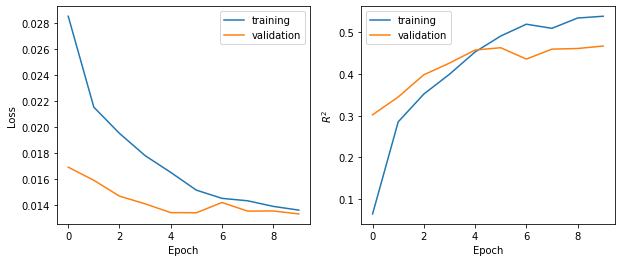

In [18]:
 # Let's plot the change in loss and categorical_accuracy

fig, axs = plt.subplots(1, 2, figsize = (10,4))

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['r_square_metric'], label='training')
axs[1].plot(history.history['val_r_square_metric'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('$R^2$')
axs[1].legend();

### 2.3 Model Performance

In [19]:
Ptrain = model.predict(Xtrain).squeeze()
Pval = model.predict(Xval).squeeze()

Text(0.5, 1.0, 'CNN Reflectivity')

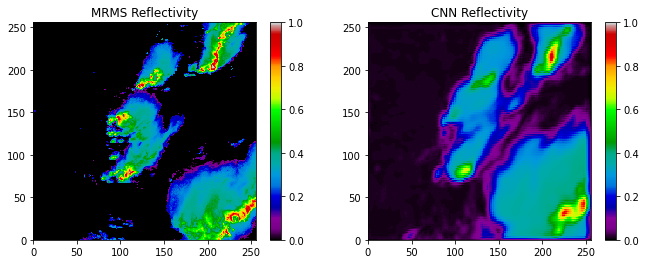

In [20]:
### Let's take a look at our prediction on the validation data

IMG = 47

fig, axs = plt.subplots(1,2, figsize=(11,4))
pcm = axs[0].pcolormesh(Tval[IMG], cmap='nipy_spectral', vmin=0, vmax=1)
plt.colorbar(pcm, ax = axs[0])
pcm = axs[1].pcolormesh(Pval[IMG], cmap='nipy_spectral', vmin=0, vmax=1)
plt.colorbar(pcm, ax = axs[1])
axs[0].set_title('MRMS Reflectivity')
axs[1].set_title('CNN Reflectivity')


Let's plot a the probability density for various MRMS reflectivity bins. Below, we can see that our network does a *decent* job, but it under estimates the highest reflectivities.

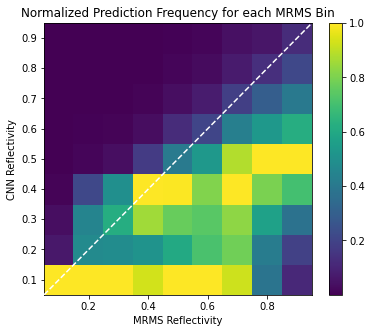

In [21]:
# How often is the CNN prediction over/under-estimating the true reflectivity?
plt.figure(figsize=(6,5))

mrms_bins = np.arange(0,1, .1)
cnn_bins = np.arange(0,1, .1)

NOVAL = np.zeros(Pval.shape)

bins = np.zeros((len(mrms_bins), len(cnn_bins)))

for ib, mb in enumerate(mrms_bins):
  for jb, cb in enumerate(cnn_bins):
    bins[ib, jb] = np.sum(np.logical_and(np.logical_and(Tval >= mb, Tval <= mb + .1), 
                                         np.logical_and(Pval >= cb, Pval <= cb + .1)))
bins = bins.T

plt.pcolormesh(mrms_bins+.05, cnn_bins+.05, bins/np.max(bins, axis=0))
plt.title('Normalized Prediction Frequency for each MRMS Bin')
plt.ylabel('CNN Reflectivity')
plt.xlabel('MRMS Reflectivity')
plt.colorbar()

plt.plot(mrms_bins+.05, cnn_bins+.05, [.05,.05], [.95,.95], color='white', 
         linestyle = '--', zorder=4)

plt.show()

It can also be good to look at the pattern correlation. Here, we look at $R^2$ Score.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


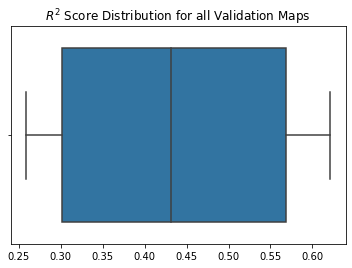

In [22]:
# What does our distribution of R^2 Score look like?

def rsq(y_true, y_pred):  
  ss_res = np.sum(np.square(y_true-y_pred))
  ss_tot = np.sum(np.square(y_true-np.mean(y_true)))
  return ( 1 - ss_res/(ss_tot + 10**-16) )

rsq_list = []
for pmap, tmap in zip(Pval, Tval):
  rsq_list.append(rsq(tmap, pmap))

sb.boxplot(rsq_list)
plt.title('$R^2$ Score Distribution for all Validation Maps')
plt.show()

# 3. Model Competition

We have set aside a bunch of ozone data. Tune your model to the best of your abilities, and we will see how it performed at the end of class. Specifically, we will be using Weighted Categorical Accuracy to measure model performance. **EDIT the code below to test.**

In [23]:
CODE = '' # Hint, it's test...

DO NOT EDIT THE FOLLOWING:

In [24]:
def compete():

  Xcompete = data['Xdata_' + CODE].values
  Tcompete = data['Ydata_' + CODE].values

  Pcompete = model.predict(Xcompete).squeeze()

  print('Congrats! Your median R^2 Score is:', rsq(Tcompete, Pcompete))

In [25]:
compete()

KeyError: ignored

In [ ]:
## How does it look on our testing data? 

IMG = 40

fig, axs = plt.subplots(1,2, figsize=(11,4))
pcm = axs[0].pcolormesh(Tcompete[IMG], cmap='nipy_spectral', vmin=0, vmax=1)
plt.colorbar(pcm, ax = axs[0])
pcm = axs[1].pcolormesh(Pcompete[IMG], cmap='nipy_spectral', vmin=0, vmax=1)
plt.colorbar(pcm, ax = axs[1])
axs[0].set_title('MRMS Reflectivity')
axs[1].set_title('CNN Reflectivity')
plt.show()